In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import datetime as dt
import os
import glob

In [52]:
SYMBOL = "ETHUSDC"

START_TIME = dt.datetime(year=2025, month=5, day=7, hour=0, minute=0, second=0, microsecond=0)
END_TIME = dt.datetime(year=2025, month=5, day=31, hour=0, minute=0, second=0, microsecond=0)
UPPER_PRICE = 2700
LOWER_PRICE = 2350

print(f"📋 Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Period: {START_TIME.strftime('%Y-%m-%d')} to {END_TIME.strftime('%Y-%m-%d')} ({(END_TIME - START_TIME).days} days)")
print(f"   Price Range: ${LOWER_PRICE:,.2f} - ${UPPER_PRICE:,.2f}")
print(f"   Center Price: ${(UPPER_PRICE + LOWER_PRICE) / 2:,.2f}")

📋 Configuration:
   Symbol: ETHUSDC
   Period: 2025-05-07 to 2025-05-31 (24 days)
   Price Range: $2,350.00 - $2,700.00
   Center Price: $2,525.00


In [53]:
# Load data from CSV file
def find_csv():
    csv_files = glob.glob(f"./research/simulation/data/{SYMBOL}_hourly_data_*.csv")
    return csv_files

def load_data(filename=None):    
    if filename is None:
        # Try to find CSV files automatically
        csv_files = find_csv()
        
        if not csv_files:
            print("No CSV files found in current directory.")
            print("Please ensure you have run the data fetching notebook first.")
            return None
        
        # Use the most recent file
        filename = max(csv_files, key=os.path.getctime)
        print(f"Found {len(csv_files)} CSV file(s)")
        print(f"Using most recent file: {filename}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        
        # Convert timestamp columns to datetime
        df['open_time'] = pd.to_datetime(df['open_time'])
        df['close_time'] = pd.to_datetime(df['close_time'])
        
        # Ensure data types are correct
        price_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
        for col in price_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by open_time to ensure chronological order
        df = df.sort_values('open_time').reset_index(drop=True)
        
        print(f"Successfully loaded {SYMBOL} data!")
        print(f"Dataset: {len(df):,} hourly records")
        print(f"Period: {df['open_time'].min().strftime('%Y-%m-%d %H:%M')} to {df['open_time'].max().strftime('%Y-%m-%d %H:%M')}")
        
        return df
        
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        print("Please check the filename and try again.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()


Found 1 CSV file(s)
Using most recent file: ./research/simulation/data/ETHUSDC_hourly_data_20240701_20250701.csv
Successfully loaded ETHUSDC data!
Dataset: 8,761 hourly records
Period: 2024-06-30 17:00 to 2025-06-30 17:00


In [54]:
def create_range_visualization(df, start_time, end_time, upper_price, lower_price):
    """
    Visualize price data with a rectangle showing the liquidity provision range.
    
    Args:
        df: DataFrame with price data
        start_time: Start time for liquidity provision (datetime)
        end_time: End time for liquidity provision (datetime)
        upper_price: Upper price bound for liquidity provision
        lower_price: Lower price bound for liquidity provision
    """
    if df is None:
        print("❌ No data available for visualization")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot the full price history
    ax.plot(df['open_time'], df['close'], 
            color='blue', linewidth=1.5, label=f'{SYMBOL} Close Price', alpha=0.7, zorder=3)
    
    # Filter data within the specified time range for highlighting
    mask = (df['open_time'] >= start_time) & (df['open_time'] <= end_time)
    df_range = df[mask].copy()
    
    if not df_range.empty:
        # Highlight the price during the position period
        ax.plot(df_range['open_time'], df_range['close'], 
                color='orange', linewidth=2.5, label='Price during Position', zorder=4)
    
    # Create the liquidity range rectangle
    start_date_num = mdates.date2num(start_time)
    end_date_num = mdates.date2num(end_time)
    width = end_date_num - start_date_num
    height = upper_price - lower_price
    
    # Draw the rectangle
    rect = Rectangle((start_date_num, lower_price), width, height,
                     facecolor='green', alpha=0.2, 
                     edgecolor='darkgreen', linewidth=2,
                     label='Liquidity Range', zorder=2)
    ax.add_patch(rect)
    
    # Draw horizontal lines for upper and lower bounds
    ax.hlines(y=upper_price, xmin=start_date_num, xmax=end_date_num,
             colors='darkgreen', linestyles='--', linewidth=2, 
             label=f'Upper Bound: ${upper_price:,.2f}', zorder=5)
    ax.hlines(y=lower_price, xmin=start_date_num, xmax=end_date_num,
             colors='darkgreen', linestyles='--', linewidth=2,
             label=f'Lower Bound: ${lower_price:,.2f}', zorder=5)
    
    # Draw vertical lines for start and end time
    ax.axvline(x=start_time, color='red', linestyle='--', linewidth=1.5, 
               alpha=0.7, label='Position Start', zorder=5)
    ax.axvline(x=end_time, color='red', linestyle='--', linewidth=1.5,
               alpha=0.7, label='Position End', zorder=5)
    
    # Calculate center price
    center_price = (upper_price + lower_price) / 2
    ax.hlines(y=center_price, xmin=start_date_num, xmax=end_date_num,
             colors='purple', linestyles=':', linewidth=1.5,
             label=f'Center: ${center_price:,.2f}', alpha=0.8, zorder=5)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
    ax.set_title(f'{SYMBOL} Liquidity Position Visualization',
                fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))
    
    # Grid and legend
    ax.grid(True, alpha=0.3, zorder=0)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # Add info box
    range_width = ((upper_price - lower_price) / center_price) * 100
    info_text = f"Position Details:\n"
    info_text += f"Duration: {(end_time - start_time).days} days\n"
    info_text += f"Price Range: ${lower_price:,.2f} - ${upper_price:,.2f}\n"
    info_text += f"Range Width: ±{range_width/2:.2f}%\n"
    
    if not df_range.empty:
        in_range = df_range[(df_range['close'] >= lower_price) & (df_range['close'] <= upper_price)]
        in_range_pct = (len(in_range) / len(df_range)) * 100
        info_text += f"In Range: {in_range_pct:.1f}% of time"
    
    ax.text(0.02, 0.98, info_text, 
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if not df_range.empty:
        print("\n📊 POSITION STATISTICS")
        print("=" * 50)
        print(f"Position Duration: {(end_time - start_time).days} days ({(end_time - start_time).total_seconds() / 3600:.1f} hours)")
        print(f"Price Range: ${lower_price:,.2f} - ${upper_price:,.2f}")
        print(f"Center Price: ${center_price:,.2f}")
        print(f"Range Width: ±{range_width/2:.2f}%")
        print(f"\n📈 PRICE BEHAVIOR DURING POSITION")
        print("-" * 50)
        in_range = df_range[(df_range['close'] >= lower_price) & (df_range['close'] <= upper_price)]
        out_of_range = df_range[(df_range['close'] > upper_price) | (df_range['close'] < lower_price)]
        print(f"Hours in range: {len(in_range)} ({len(in_range)/len(df_range)*100:.1f}%)")
        print(f"Hours out of range: {len(out_of_range)} ({len(out_of_range)/len(df_range)*100:.1f}%)")
        print(f"Min price: ${df_range['close'].min():,.2f}")
        print(f"Max price: ${df_range['close'].max():,.2f}")
        print(f"Avg price: ${df_range['close'].mean():,.2f}")
        
        # Check if price ever went above or below
        above = df_range[df_range['close'] > upper_price]
        below = df_range[df_range['close'] < lower_price]
        if not above.empty:
            print(f"\n⚠️  Price exceeded upper bound {len(above)} times")
            print(f"   First time: {above.iloc[0]['open_time'].strftime('%Y-%m-%d %H:%M')}")
            print(f"   Max price: ${above['close'].max():,.2f}")
        if not below.empty:
            print(f"\n⚠️  Price fell below lower bound {len(below)} times")
            print(f"   First time: {below.iloc[0]['open_time'].strftime('%Y-%m-%d %H:%M')}")
            print(f"   Min price: ${below['close'].min():,.2f}")

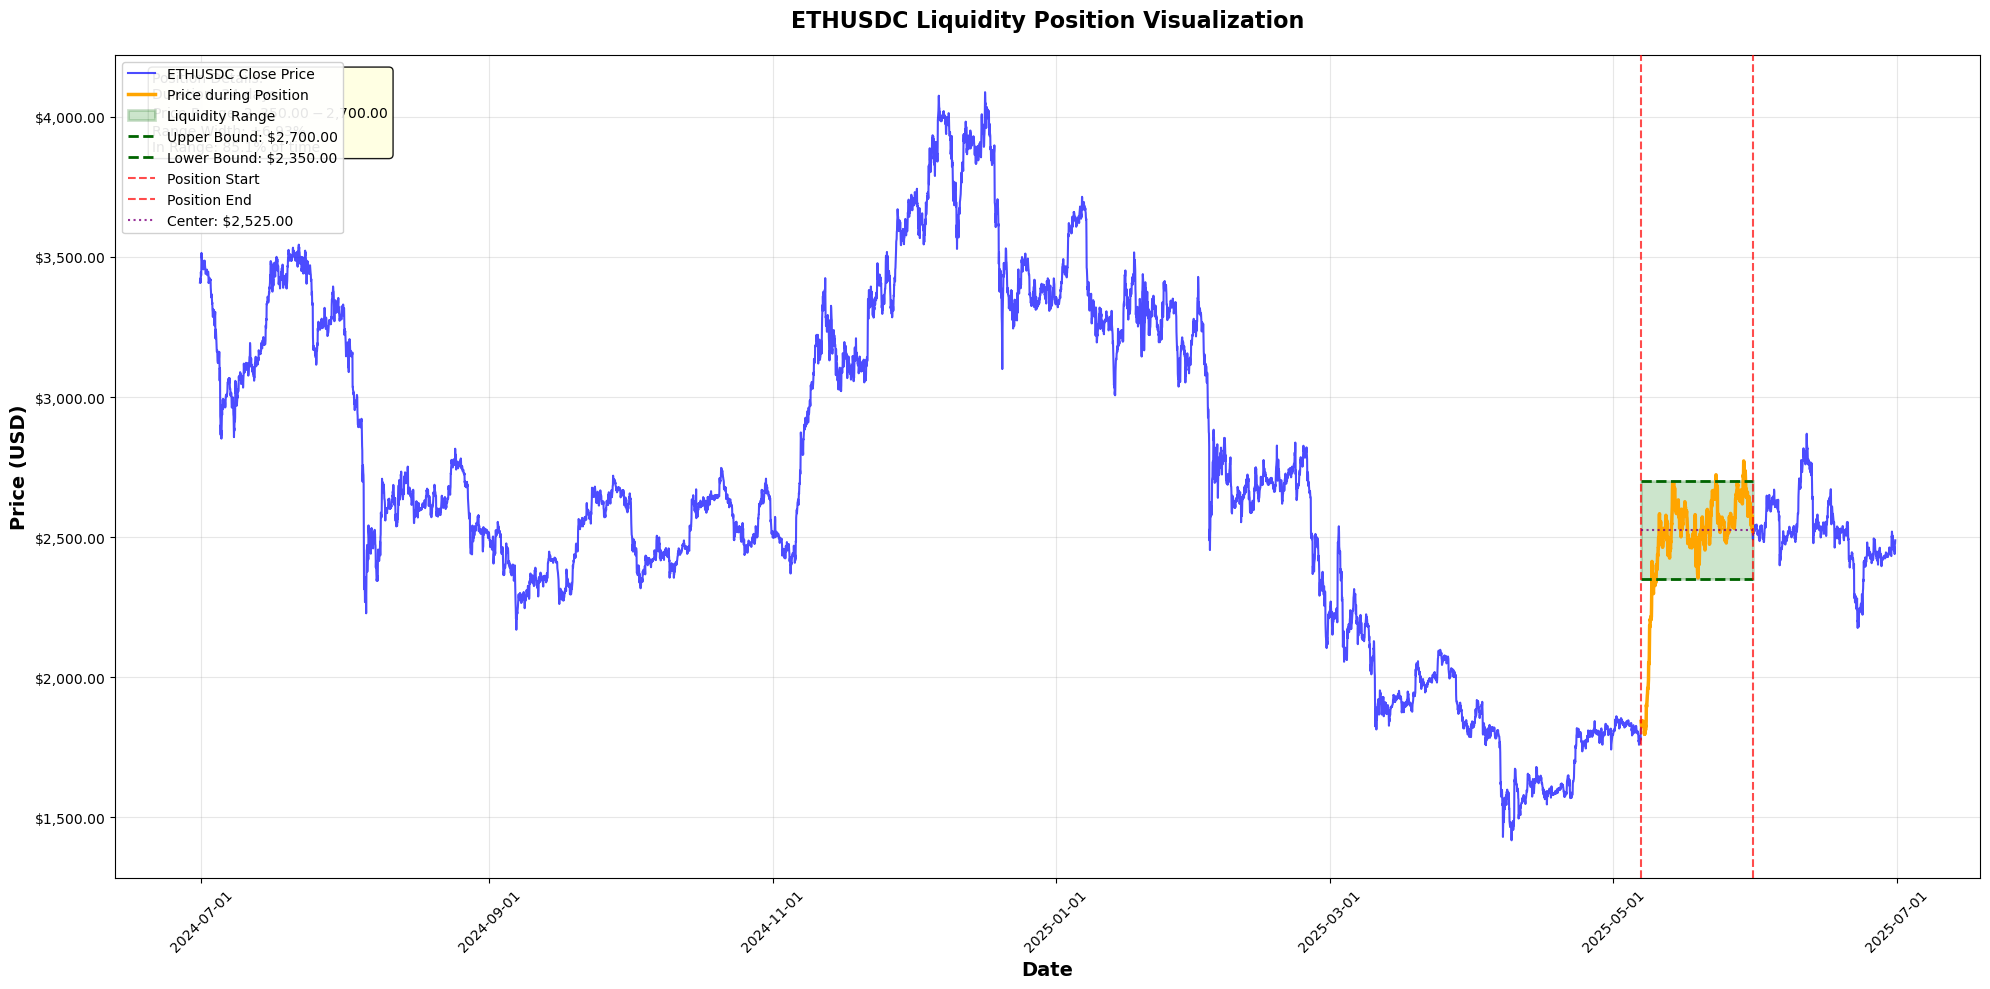


📊 POSITION STATISTICS
Position Duration: 24 days (576.0 hours)
Price Range: $2,350.00 - $2,700.00
Center Price: $2,525.00
Range Width: ±6.93%

📈 PRICE BEHAVIOR DURING POSITION
--------------------------------------------------
Hours in range: 491 (85.1%)
Hours out of range: 86 (14.9%)
Min price: $1,796.04
Max price: $2,771.80
Avg price: $2,491.47

⚠️  Price exceeded upper bound 14 times
   First time: 2025-05-23 02:00
   Max price: $2,771.80

⚠️  Price fell below lower bound 72 times
   First time: 2025-05-07 00:00
   Min price: $1,796.04


In [55]:
create_range_visualization(df, START_TIME, END_TIME, UPPER_PRICE, LOWER_PRICE)